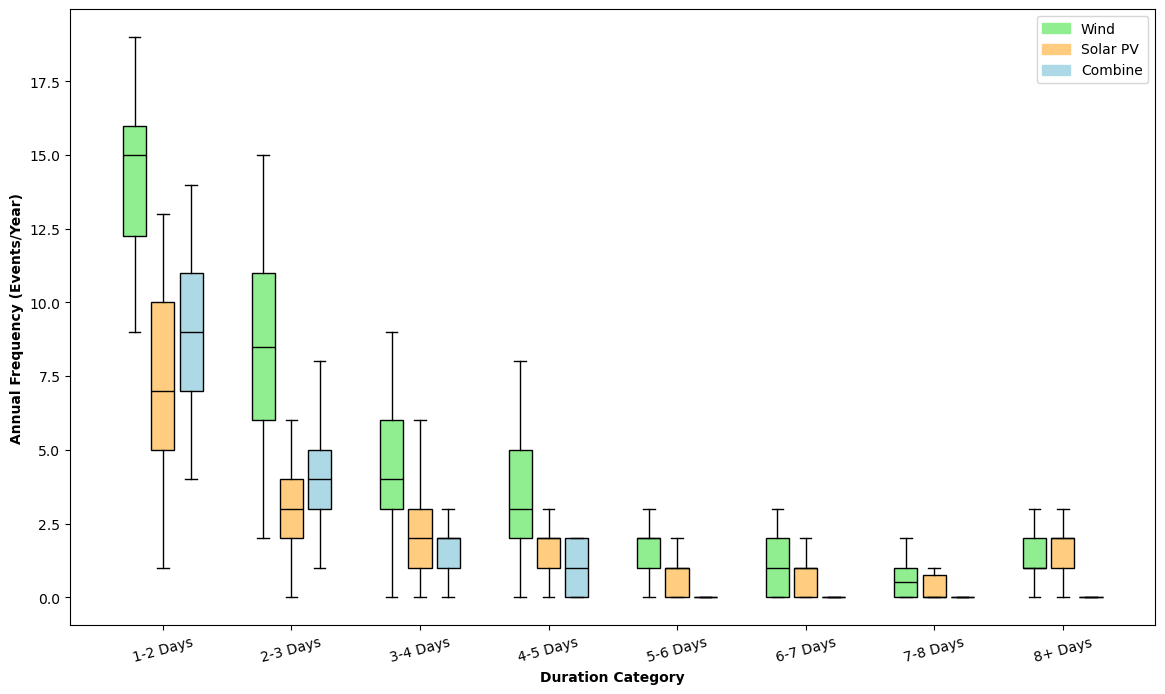

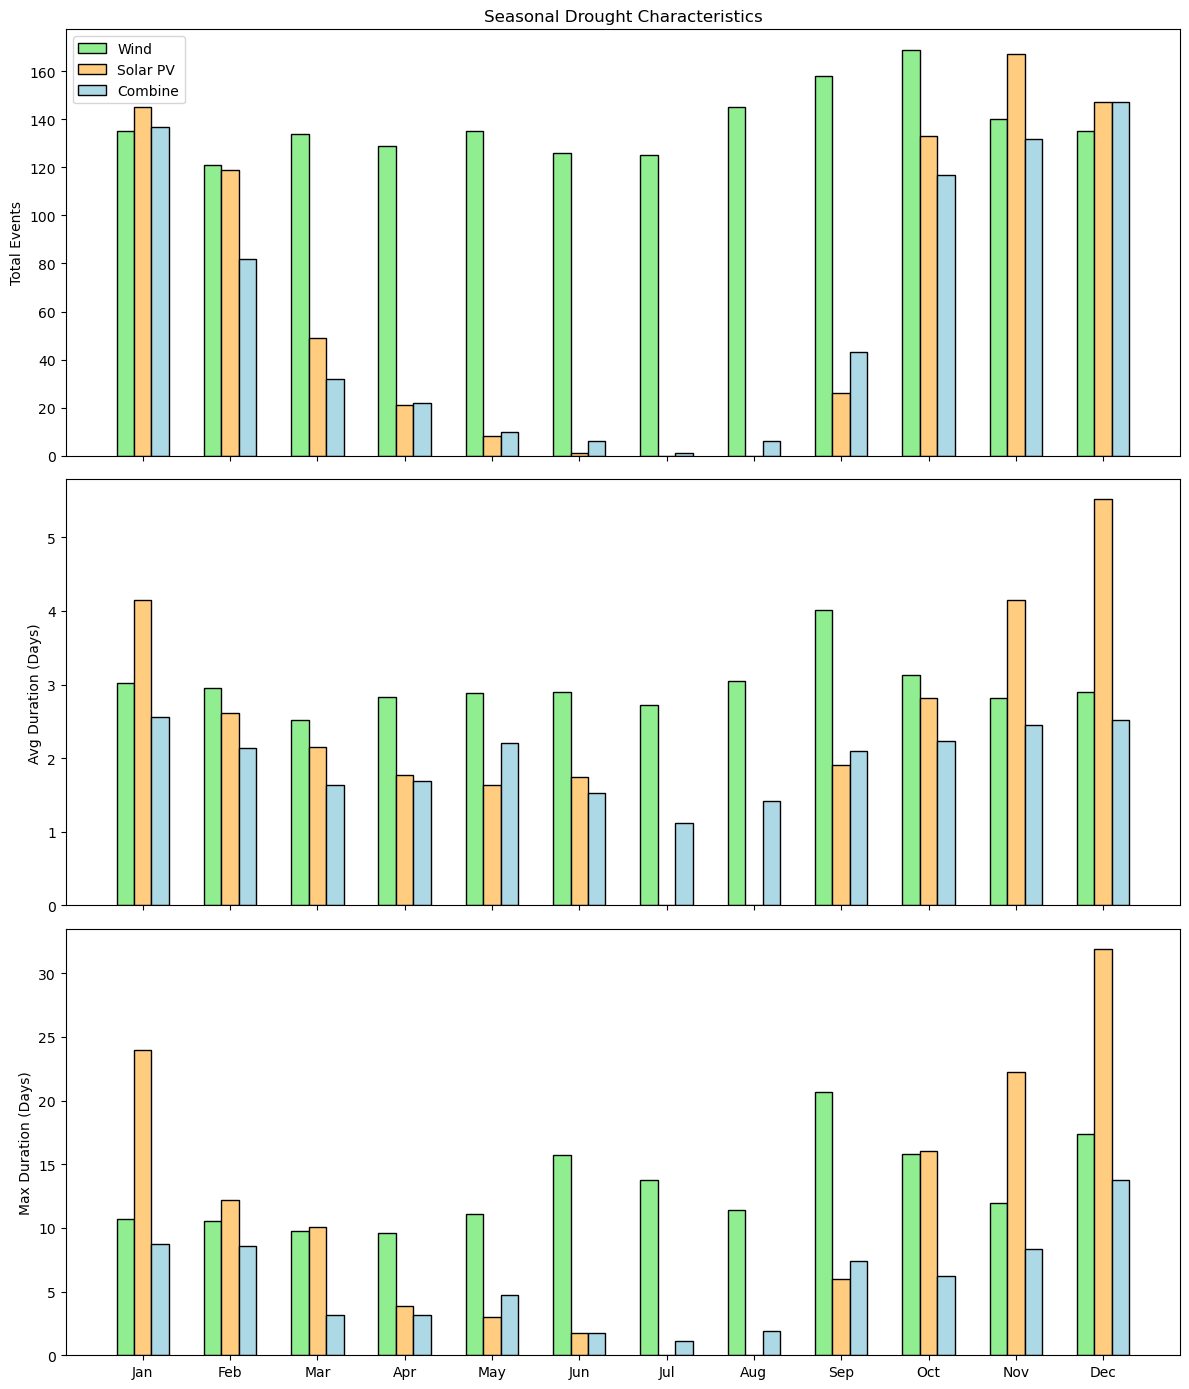

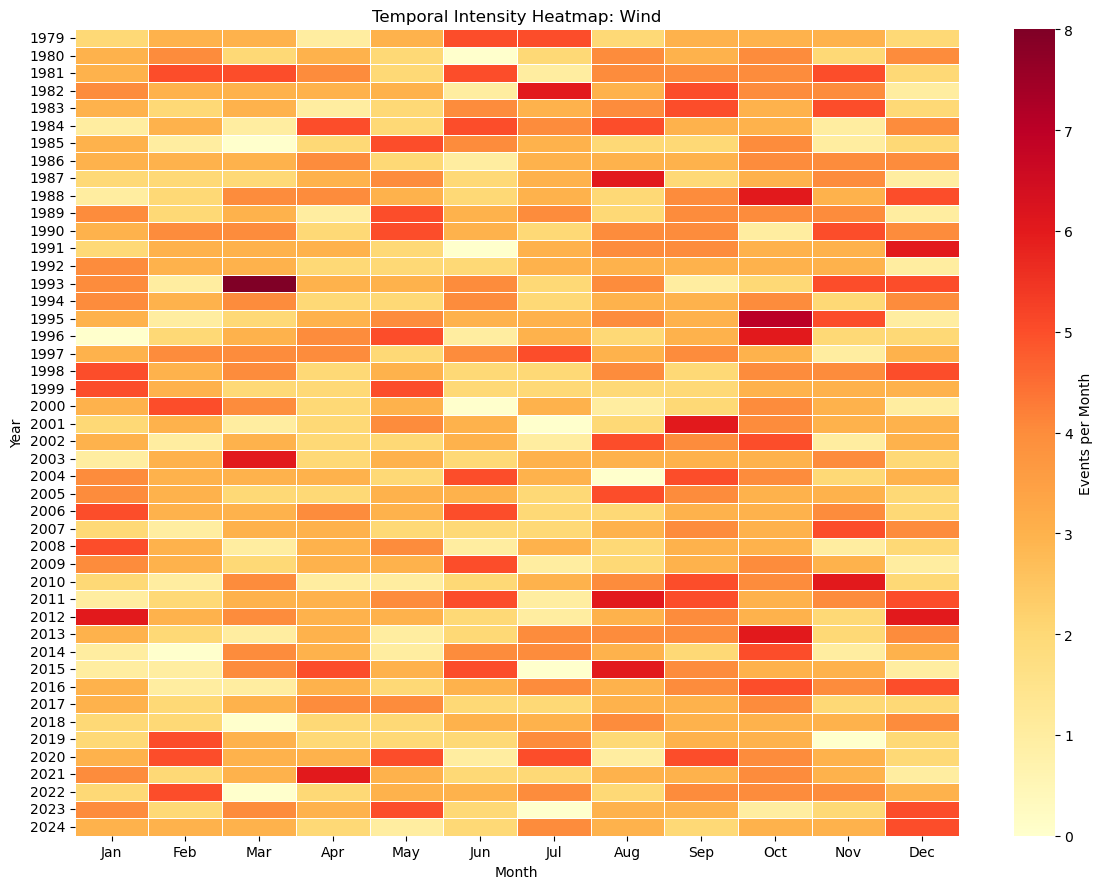

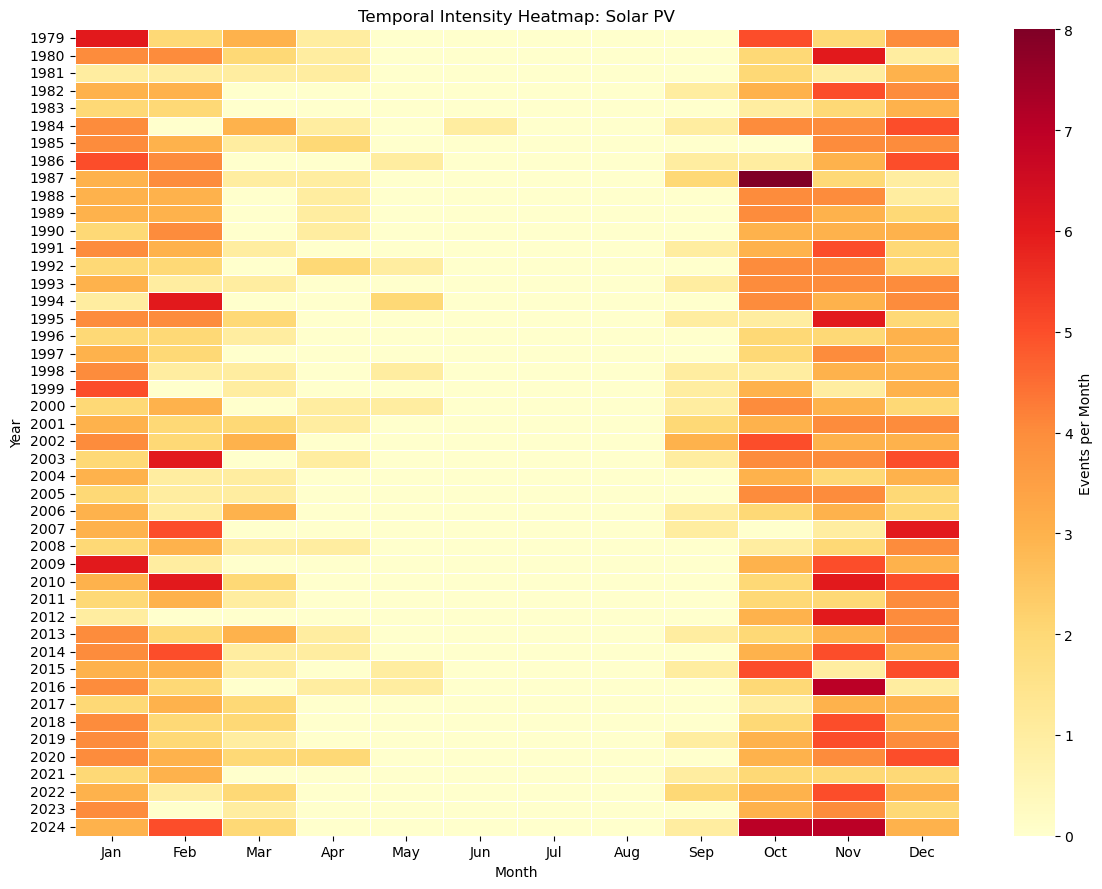

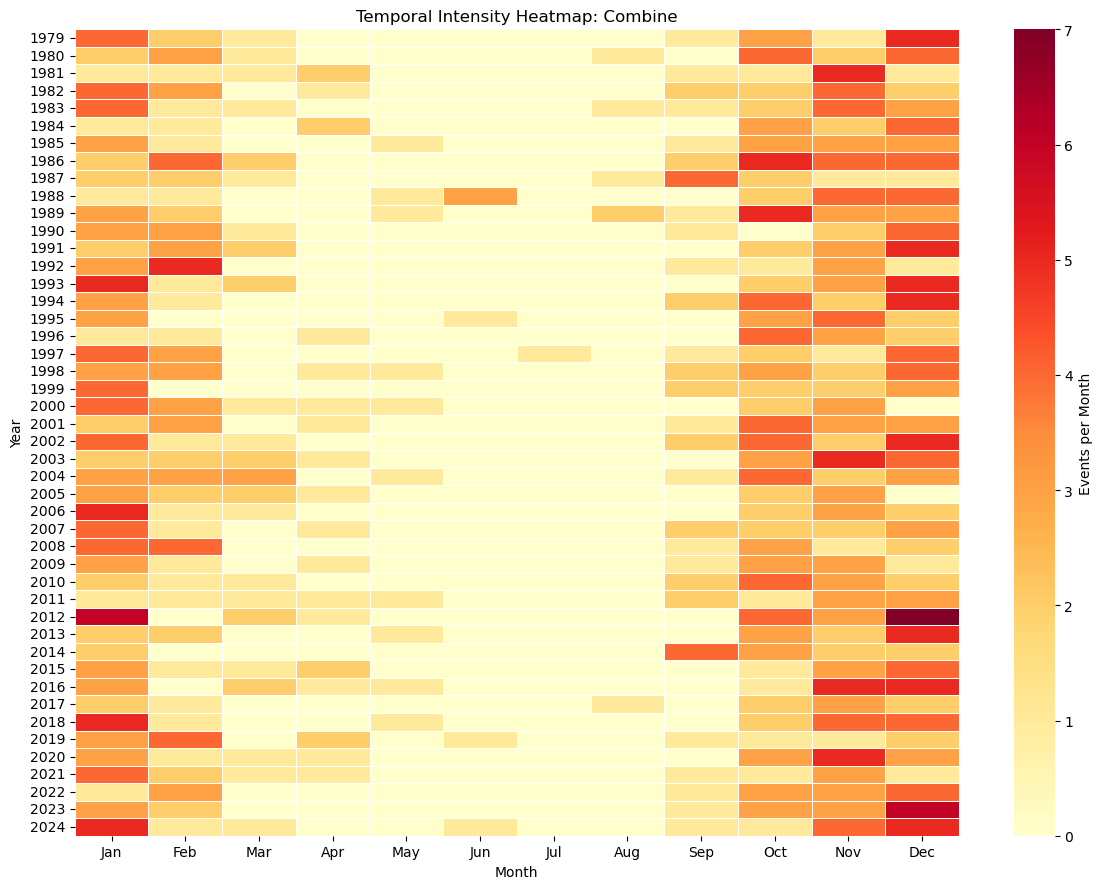

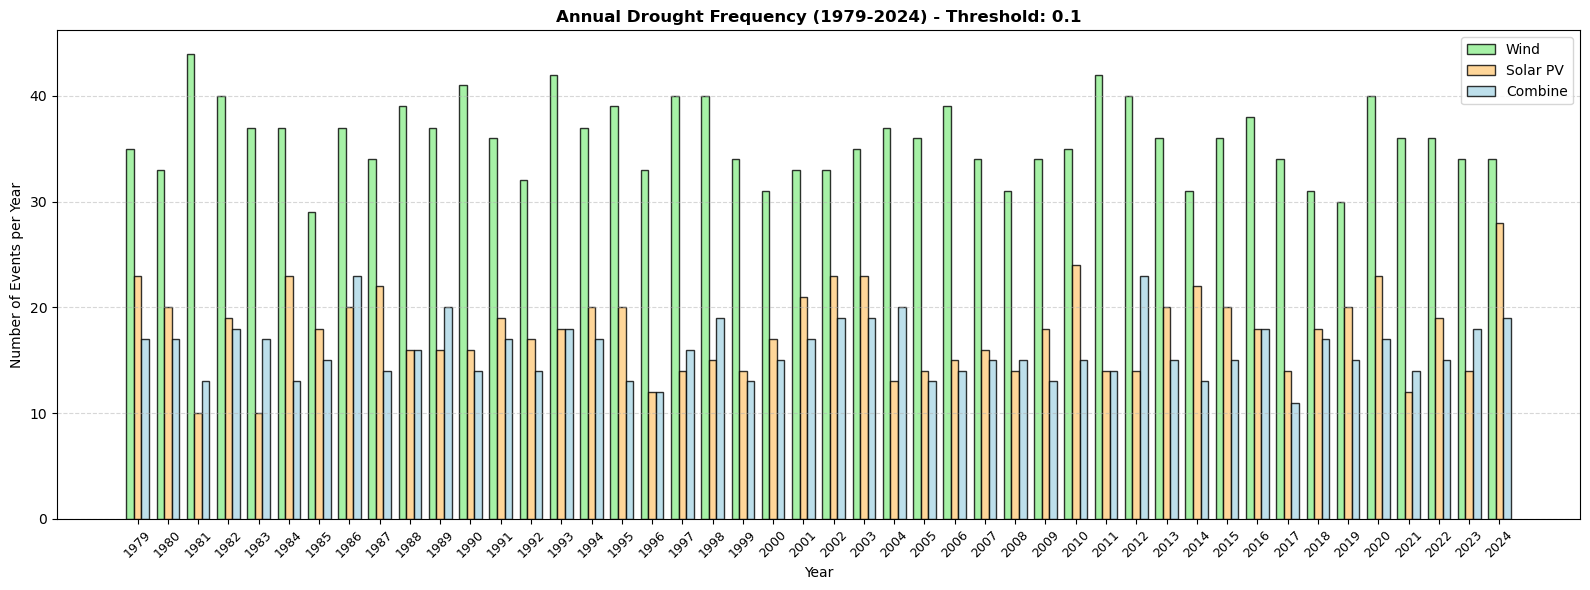

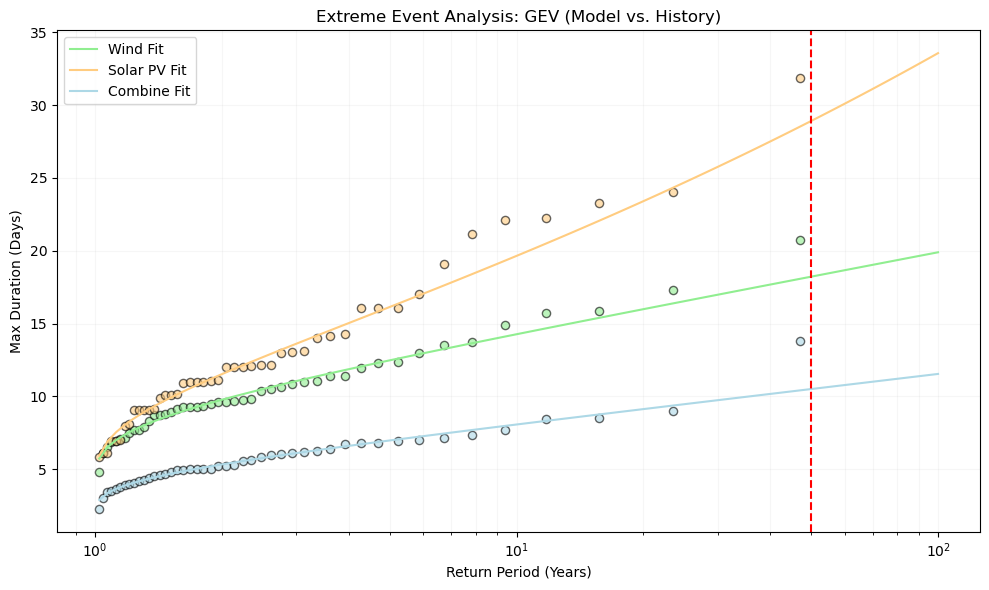

All outputs were generated.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
from scipy.stats import linregress
from scipy.stats import genextreme as gev

# ------------------------------------------------ 
# 1. Configuration & Parameters - user defined:
# ensure  data quality to avoid: Missing timestamps, Duplicate hours, etc
# -------------------------------------------------
input_file = '../Data/cf_dummy_Own.csv'
columns_to_analyze = ['Wind', 'Solar PV', 'Combine']
threshold = 0.1 
output_dir = './Results'
os.makedirs(output_dir, exist_ok=True)

# Formatting Constants
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192,  np.inf]
duration_labels = ['1-2 Days', '2-3 Days', '3-4 Days', '4-5 Days', 
                   '5-6 Days', '6-7 Days', '7-8 Days', '8+ Days']
month_index = range(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors_dict = {'Wind': '#90EE90', 'Solar PV': '#FFCC80', 'Combine': '#ADD8E6'}

# ------------------------------------------------ 
#  Data Processing & Detection
# -------------------------------------------------
df_cf = pd.read_csv(input_file, index_col=0, parse_dates=True)
df_cf_avg = df_cf.rolling('D', min_periods=24, center=True).mean()

all_years = sorted(df_cf.index.year.unique())
total_years = len(all_years)

def identify_drought(time_series, thresh):
    events_thresh = time_series < thresh
    groups = events_thresh.ne(events_thresh.shift()).cumsum()
    drought_only = events_thresh[events_thresh == True]
    raw = drought_only.groupby(groups).cumcount() + 1
    identified = raw[(raw.shift(-1).fillna(0) < raw)]
    starts = [d - pd.Timedelta(identified.loc[d]-1, unit='h') for d in identified.index]
    res = pd.DataFrame({
        'Start_Date': starts, 'End_Date': identified.index, 
        'Duration_h': identified.values, 'Duration_d': identified.values / 24,
        'Year': [s.year for s in starts], 'Month': [s.month for s in starts]
    })
    return res[res['Duration_h'] > 24]

droughts_dict = {col: identify_drought(df_cf_avg[col], threshold) for col in columns_to_analyze}

# -----------------------------------------------------------------------------
#   COMPARATIVE BOXPLOT (Annual Variability)
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))
freq_duration_list = []
for i, col in enumerate(columns_to_analyze):
    df = droughts_dict[col].copy()
    if not df.empty:
        df['Bin'] = pd.cut(df['Duration_h'], bins=duration_ranges_hours, labels=duration_labels, right=True)
        counts_per_year = df.groupby(['Year', 'Bin'], observed=False).size().unstack(fill_value=0).reindex(index=all_years, fill_value=0)
        data_to_plot = [counts_per_year[b].values for b in duration_labels]
        ax.boxplot(data_to_plot, positions=np.arange(1, 9) + i*0.22 - 0.22, widths=0.18, patch_artist=True, 
                   boxprops=dict(facecolor=colors_dict[col]), medianprops=dict(color='black'), showfliers=False)
        freq_duration_list.append(df['Bin'].value_counts().reindex(duration_labels, fill_value=0).rename(col))

ax.set_xticks(np.arange(1, 9)); ax.set_xticklabels(duration_labels, rotation=15)
ax.set_ylabel('Annual Frequency (Events/Year)', fontweight='bold'); ax.set_xlabel('Duration Category', fontweight='bold')
plt.legend(handles=[mpatches.Patch(color=colors_dict[l], label=l) for l in columns_to_analyze])
plt.savefig(os.path.join(output_dir, '03_Boxplot_Comparison.png'), dpi=300); plt.show()
# -----------------------------------------------------------------------------
#  SEASONAL DISTRIBUTIONS (Monthly Count, Mean, Max)
# -----------------------------------------------------------------------------
monthly_stats_list = []
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

for i, col in enumerate(columns_to_analyze):
    df = droughts_dict[col]
    m_stats = df.groupby('Month')['Duration_d'].agg(['count', 'mean', 'max']).reindex(month_index, fill_value=0)
    
    for m in month_index:
        monthly_stats_list.append({
            'Technology': col, 'Month': m, 'Count': m_stats.loc[m, 'count'],
            'Mean_Days': round(m_stats.loc[m, 'mean'], 2), 'Max_Days': round(m_stats.loc[m, 'max'], 2)
        })

    axes[0].bar(np.arange(1, 13) + (i*0.2 - 0.2), m_stats['count'], width=0.2, color=colors_dict[col], edgecolor='black', label=col)
    axes[1].bar(np.arange(1, 13) + (i*0.2 - 0.2), m_stats['mean'], width=0.2, color=colors_dict[col], edgecolor='black')
    axes[2].bar(np.arange(1, 13) + (i*0.2 - 0.2), m_stats['max'], width=0.2, color=colors_dict[col], edgecolor='black')

axes[0].set_title('Seasonal Drought Characteristics'); axes[0].set_ylabel('Total Events'); axes[0].legend()
axes[1].set_ylabel('Avg Duration (Days)'); axes[2].set_ylabel('Max Duration (Days)')
plt.xticks(range(1, 13), month_names); plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_Monthly_Distribution.png'), dpi=300); plt.show()

# -----------------------------------------------------------------------------
#   TEMPORAL INTENSITY HEATMAPS
# -----------------------------------------------------------------------------

for col in columns_to_analyze:
    df = droughts_dict[col]
    heatmap_data = pd.crosstab(df['Year'], df['Month']).reindex(index=all_years, columns=month_index, fill_value=0)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, linewidths=.5, cbar_kws={'label': 'Events per Month'})
    plt.title(f'Temporal Intensity Heatmap: {col}'); plt.xlabel('Month'); plt.ylabel('Year')
    plt.xticks(np.arange(0.5, 12.5), month_names)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'02_Heatmap_{col.replace(" ", "_")}.png'), dpi=300); plt.show()
# -----------------------------------------------------------------------------
# ANNUAL EVENT FREQUENCY (Events per Year Timeline)
# -----------------------------------------------------------------------------
plt.figure(figsize=(16, 6))

 
yearly_counts_df = pd.DataFrame(index=all_years)
for col in columns_to_analyze:
    counts = droughts_dict[col].groupby('Year').size().reindex(all_years, fill_value=0)
    yearly_counts_df[col] = counts

# Plotting
x_axis = np.arange(len(all_years))
width = 0.25

for i, col in enumerate(columns_to_analyze):
    plt.bar(x_axis + (i * width - width), yearly_counts_df[col], 
            width=width, color=colors_dict[col], edgecolor='black', label=col, alpha=0.8)



plt.title(f'Annual Drought Frequency (1979-2024) - Threshold: {threshold}', fontweight='bold')
plt.ylabel('Number of Events per Year')
plt.xlabel('Year')
plt.xticks(x_axis, all_years, rotation=45, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(output_dir, '00_Annual_Frequency_Timeline.png'), dpi=300)
plt.show()
# -----------------------------------------------------------------------------
#  GEV EXTREME VALUE ANALYSIS  
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
rp_export_data = []
target_rps = [10, 20, 30, 40, 50]

for col in columns_to_analyze:
    df = droughts_dict[col]
    if df.empty: continue
    yearly_max = df.groupby('Year')['Duration_d'].max().sort_values()
    n = len(yearly_max)
    empirical_rp = (n + 1) / (n + 1 - np.arange(1, n + 1))
    
    shape, loc, scale = gev.fit(yearly_max.values)
    
    for tr in target_rps:
        est_val = gev.ppf(1 - 1/tr, shape, loc, scale)
        idx = (np.abs(empirical_rp - tr)).argmin()
        obs_val = yearly_max.iloc[idx]
        
        rp_export_data.append({
            'Technology': col, 'Return_Period_Target': tr, 
            'GEV_Estimation_Days': round(float(est_val), 2),
            'Closest_Observed_Days': round(float(obs_val), 2)
        })

    plt.plot(np.logspace(0.01, 2, 100), gev.ppf(1 - 1/np.logspace(0.01, 2, 100), shape, loc, scale), color=colors_dict[col], label=f'{col} Fit')
    plt.scatter(empirical_rp, yearly_max, color=colors_dict[col], s=35, alpha=0.6, edgecolors='black')

plt.xscale('log'); plt.xlabel('Return Period (Years)'); plt.ylabel('Max Duration (Days)')
plt.title('Extreme Event Analysis: GEV (Model vs. History)'); plt.axvline(50, color='red', ls='--')
plt.legend(); plt.grid(True, which="both", alpha=0.1); plt.tight_layout()
plt.savefig(os.path.join(output_dir, '03_GEV_Analysis.png'), dpi=300); plt.show()

# -----------------------------------------------------------------------------
#  DATA AGGREGATION - FINAL EXCEL EXPORT
# -----------------------------------------------------------------------------

# 4.1 Yearly Stats Collection
yearly_stats = []
for yr in all_years:
    row = {'Year': yr}
    for col in columns_to_analyze:
        df_yr = droughts_dict[col][droughts_dict[col]['Year'] == yr]
        row[f'{col}_Count'] = len(df_yr)
        row[f'{col}_Mean_Days'] = round(df_yr['Duration_d'].mean(), 2) if not df_yr.empty else 0
        row[f'{col}_Max_Days'] = round(df_yr['Duration_d'].max(), 2) if not df_yr.empty else 0
    yearly_stats.append(row)

# 4.2 Summary Info Sheet
summary_info = pd.DataFrame({
    'Metric': ['Total Years Analysed', 'Capacity Factor Threshold', 'Period Start', 'Period End'] + 
              [f'Total Events Detected ({c})' for c in columns_to_analyze],
    'Value': [total_years, threshold, min(all_years), max(all_years)] + 
             [len(droughts_dict[c]) for c in columns_to_analyze]
})

# 4.3 Write All Sheets
with pd.ExcelWriter(os.path.join(output_dir, 'Output_Report.xlsx')) as writer:
    summary_info.to_excel(writer, sheet_name='Summary_Info', index=False)
    pd.DataFrame(monthly_stats_list).to_excel(writer, sheet_name='Monthly_Statistics', index=False)
    pd.DataFrame(yearly_stats).to_excel(writer, sheet_name='Yearly_Statistics', index=False)
    pd.DataFrame(rp_export_data).to_excel(writer, sheet_name='GEV_Return_Periods', index=False)
    
    # Frequency Matrix (Binned counts)
    freq_matrix = []
    for col in columns_to_analyze:
        df = droughts_dict[col].copy()
        df['Bin'] = pd.cut(df['Duration_h'], bins=duration_ranges_hours, labels=duration_labels, right=True)
        freq_matrix.append(df['Bin'].value_counts().reindex(duration_labels, fill_value=0).rename(col))
    pd.concat(freq_matrix, axis=1).T.to_excel(writer, sheet_name='Frequency_Matrix')
 
    pd.concat([droughts_dict[c].assign(Tech=c) for c in columns_to_analyze]).to_excel(writer, sheet_name='Raw_Event_Log', index=False)

print(f"All outputs were generated.")

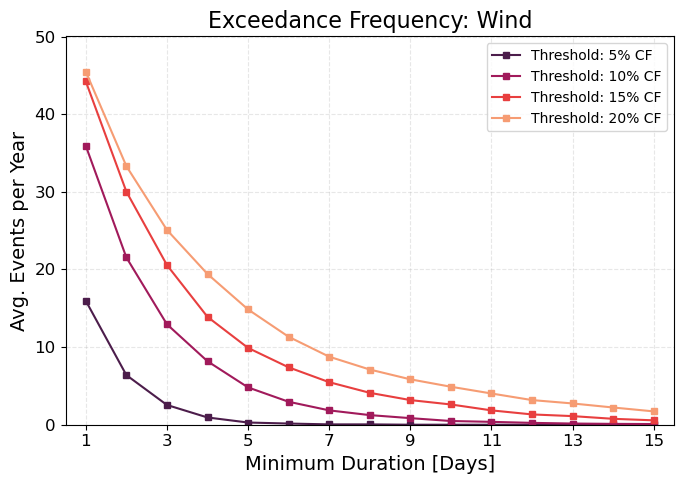

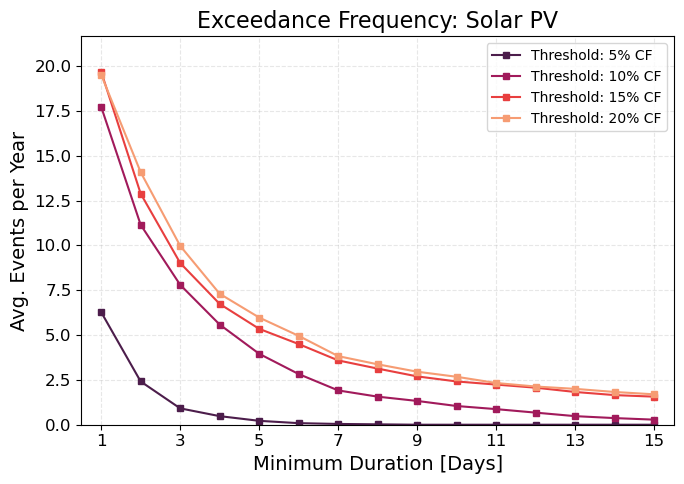

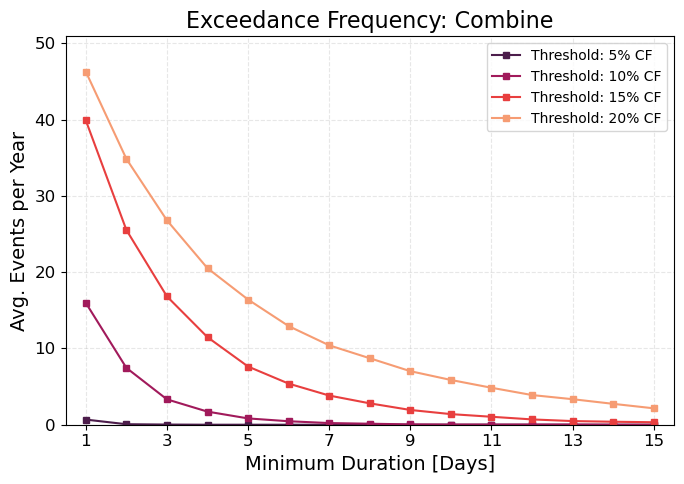

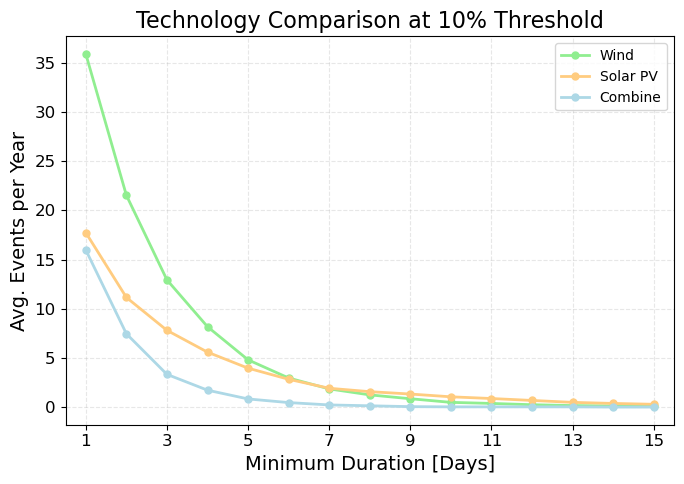

In [2]:
# -----------------------------------------------------------------------------
# Exceedance Frequency - Sensitivity Analysis
# -----------------------------------------------------------------------------
selected_threshold_for_plot = 0.10 
threshold_values = [0.05, 0.1, 0.15, 0.2]
duration_check = np.arange(1, 16, 1)
milestones = [1, 3, 5, 7, 10, 14]
sensitivity_export_list = []

plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16})

def get_exceedance_freq(durations, check_range, years):
    return [np.sum(durations >= d) / years for d in check_range]

for tech in columns_to_analyze:
    plt.figure(figsize=(7, 5)) 
    colors = sns.color_palette("rocket", len(threshold_values))
    max_y = 0

    for i, thresh in enumerate(threshold_values):
        df_res = identify_drought(df_cf_avg[tech], thresh)
        durations = df_res['Duration_d'].values
        freqs = get_exceedance_freq(durations, duration_check, total_years)
        
        plt.plot(duration_check, freqs, marker='s', markersize=4, linewidth=1.5,
                 label=f'Threshold: {int(thresh*100)}% CF', color=colors[i])
        
        if freqs: 
            max_y = max(max_y, freqs[0])

        row = {
            'Technology': tech, 'Threshold_CF': thresh, 'Total_Events': len(df_res),
            'Avg_Events_Year': round(len(df_res)/total_years, 2),
            'Max_Duration': round(durations.max(), 2) if len(durations) > 0 else 0
        }
        row.update({f'Events_GE_{d}d': np.sum(durations >= d) for d in milestones})
        sensitivity_export_list.append(row)

    plt.title(f'Exceedance Frequency: {tech}')
    plt.xlabel('Minimum Duration [Days]')
    plt.ylabel('Avg. Events per Year')
    plt.grid(True, axis='both', ls='--', alpha=0.3)
    plt.xticks(duration_check[::2])
    plt.xlim(0.5, 15.5)
    plt.ylim(0, max_y * 1.1 if max_y > 0 else 1)
    plt.legend(fontsize=10, frameon=True)
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_dir, f'Article_Sensitivity_{tech}.png'), dpi=600)
    plt.show()

# -----------------------------------------------------------------------------
# COMPARATIVE OVERLAY: PERFORMANCE AT SELECTED THRESHOLD
# -----------------------------------------------------------------------------
plt.figure(figsize=(7, 5))

for tech in columns_to_analyze:
    # Re-identify droughts for the specific selected threshold
    df_compare = identify_drought(df_cf_avg[tech], selected_threshold_for_plot)
    durations = df_compare['Duration_d'].values
    freqs = get_exceedance_freq(durations, duration_check, total_years)
    
    plt.plot(duration_check, freqs, marker='o', markersize=5, linewidth=2,
             label=f'{tech}', color=colors_dict[tech])

plt.title(f'Technology Comparison at {int(selected_threshold_for_plot*100)}% Threshold')
plt.xlabel('Minimum Duration [Days]')
plt.ylabel('Avg. Events per Year')
plt.grid(True, ls='--', alpha=0.3)
plt.xticks(duration_check[::2])
plt.xlim(0.5, 15.5)
plt.legend(fontsize=10)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, f'Article_Comparative_Overlay_{int(selected_threshold_for_plot*100)}pct.png'), dpi=600)
plt.show()

# -----------------------------------------------------------------------------
# EXCEL EXPORT 
# -----------------------------------------------------------------------------
df_sensitivity = pd.DataFrame(sensitivity_export_list)

file_path = os.path.join(output_dir, 'Output_Report.xlsx')
mode = 'a' if os.path.exists(file_path) else 'w'
if_sheet_exists = 'replace' if mode == 'a' else None

with pd.ExcelWriter(file_path, engine='openpyxl', mode=mode, if_sheet_exists=if_sheet_exists) as writer:
    df_sensitivity.to_excel(writer, sheet_name='Sensitivity_Analysis', index=False)


# Quantify the "Diversification Gain" using different metrics during droughs events: 

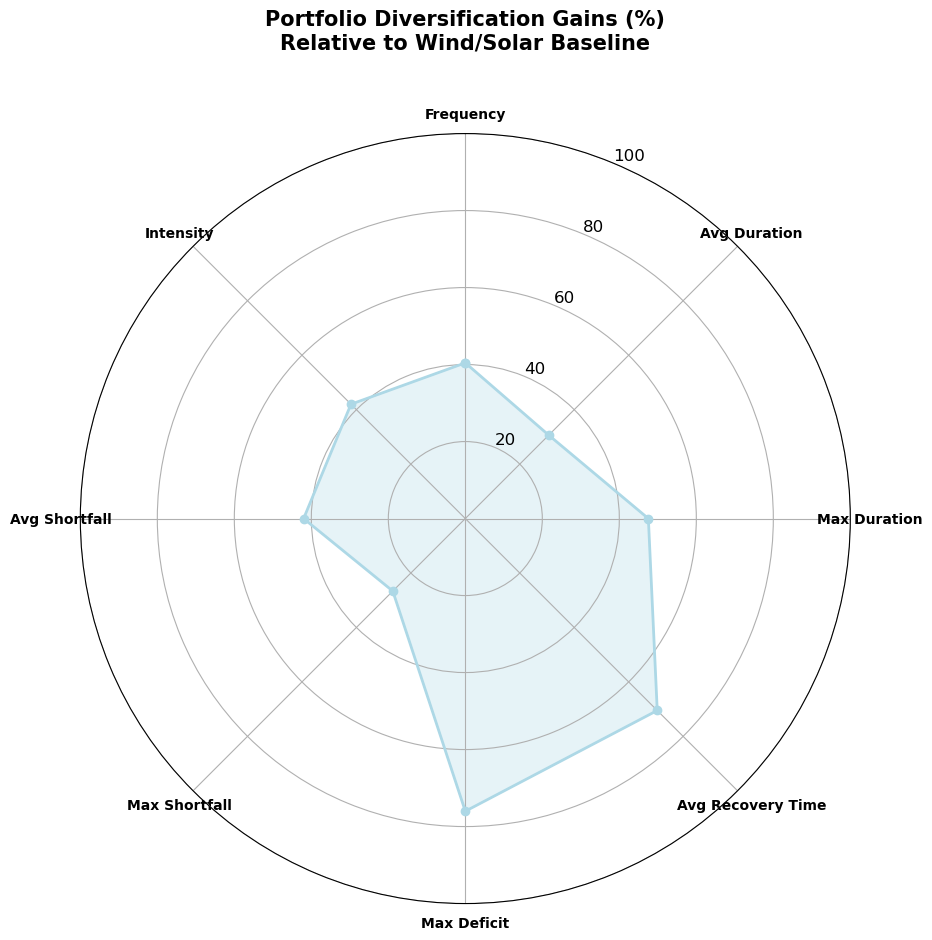

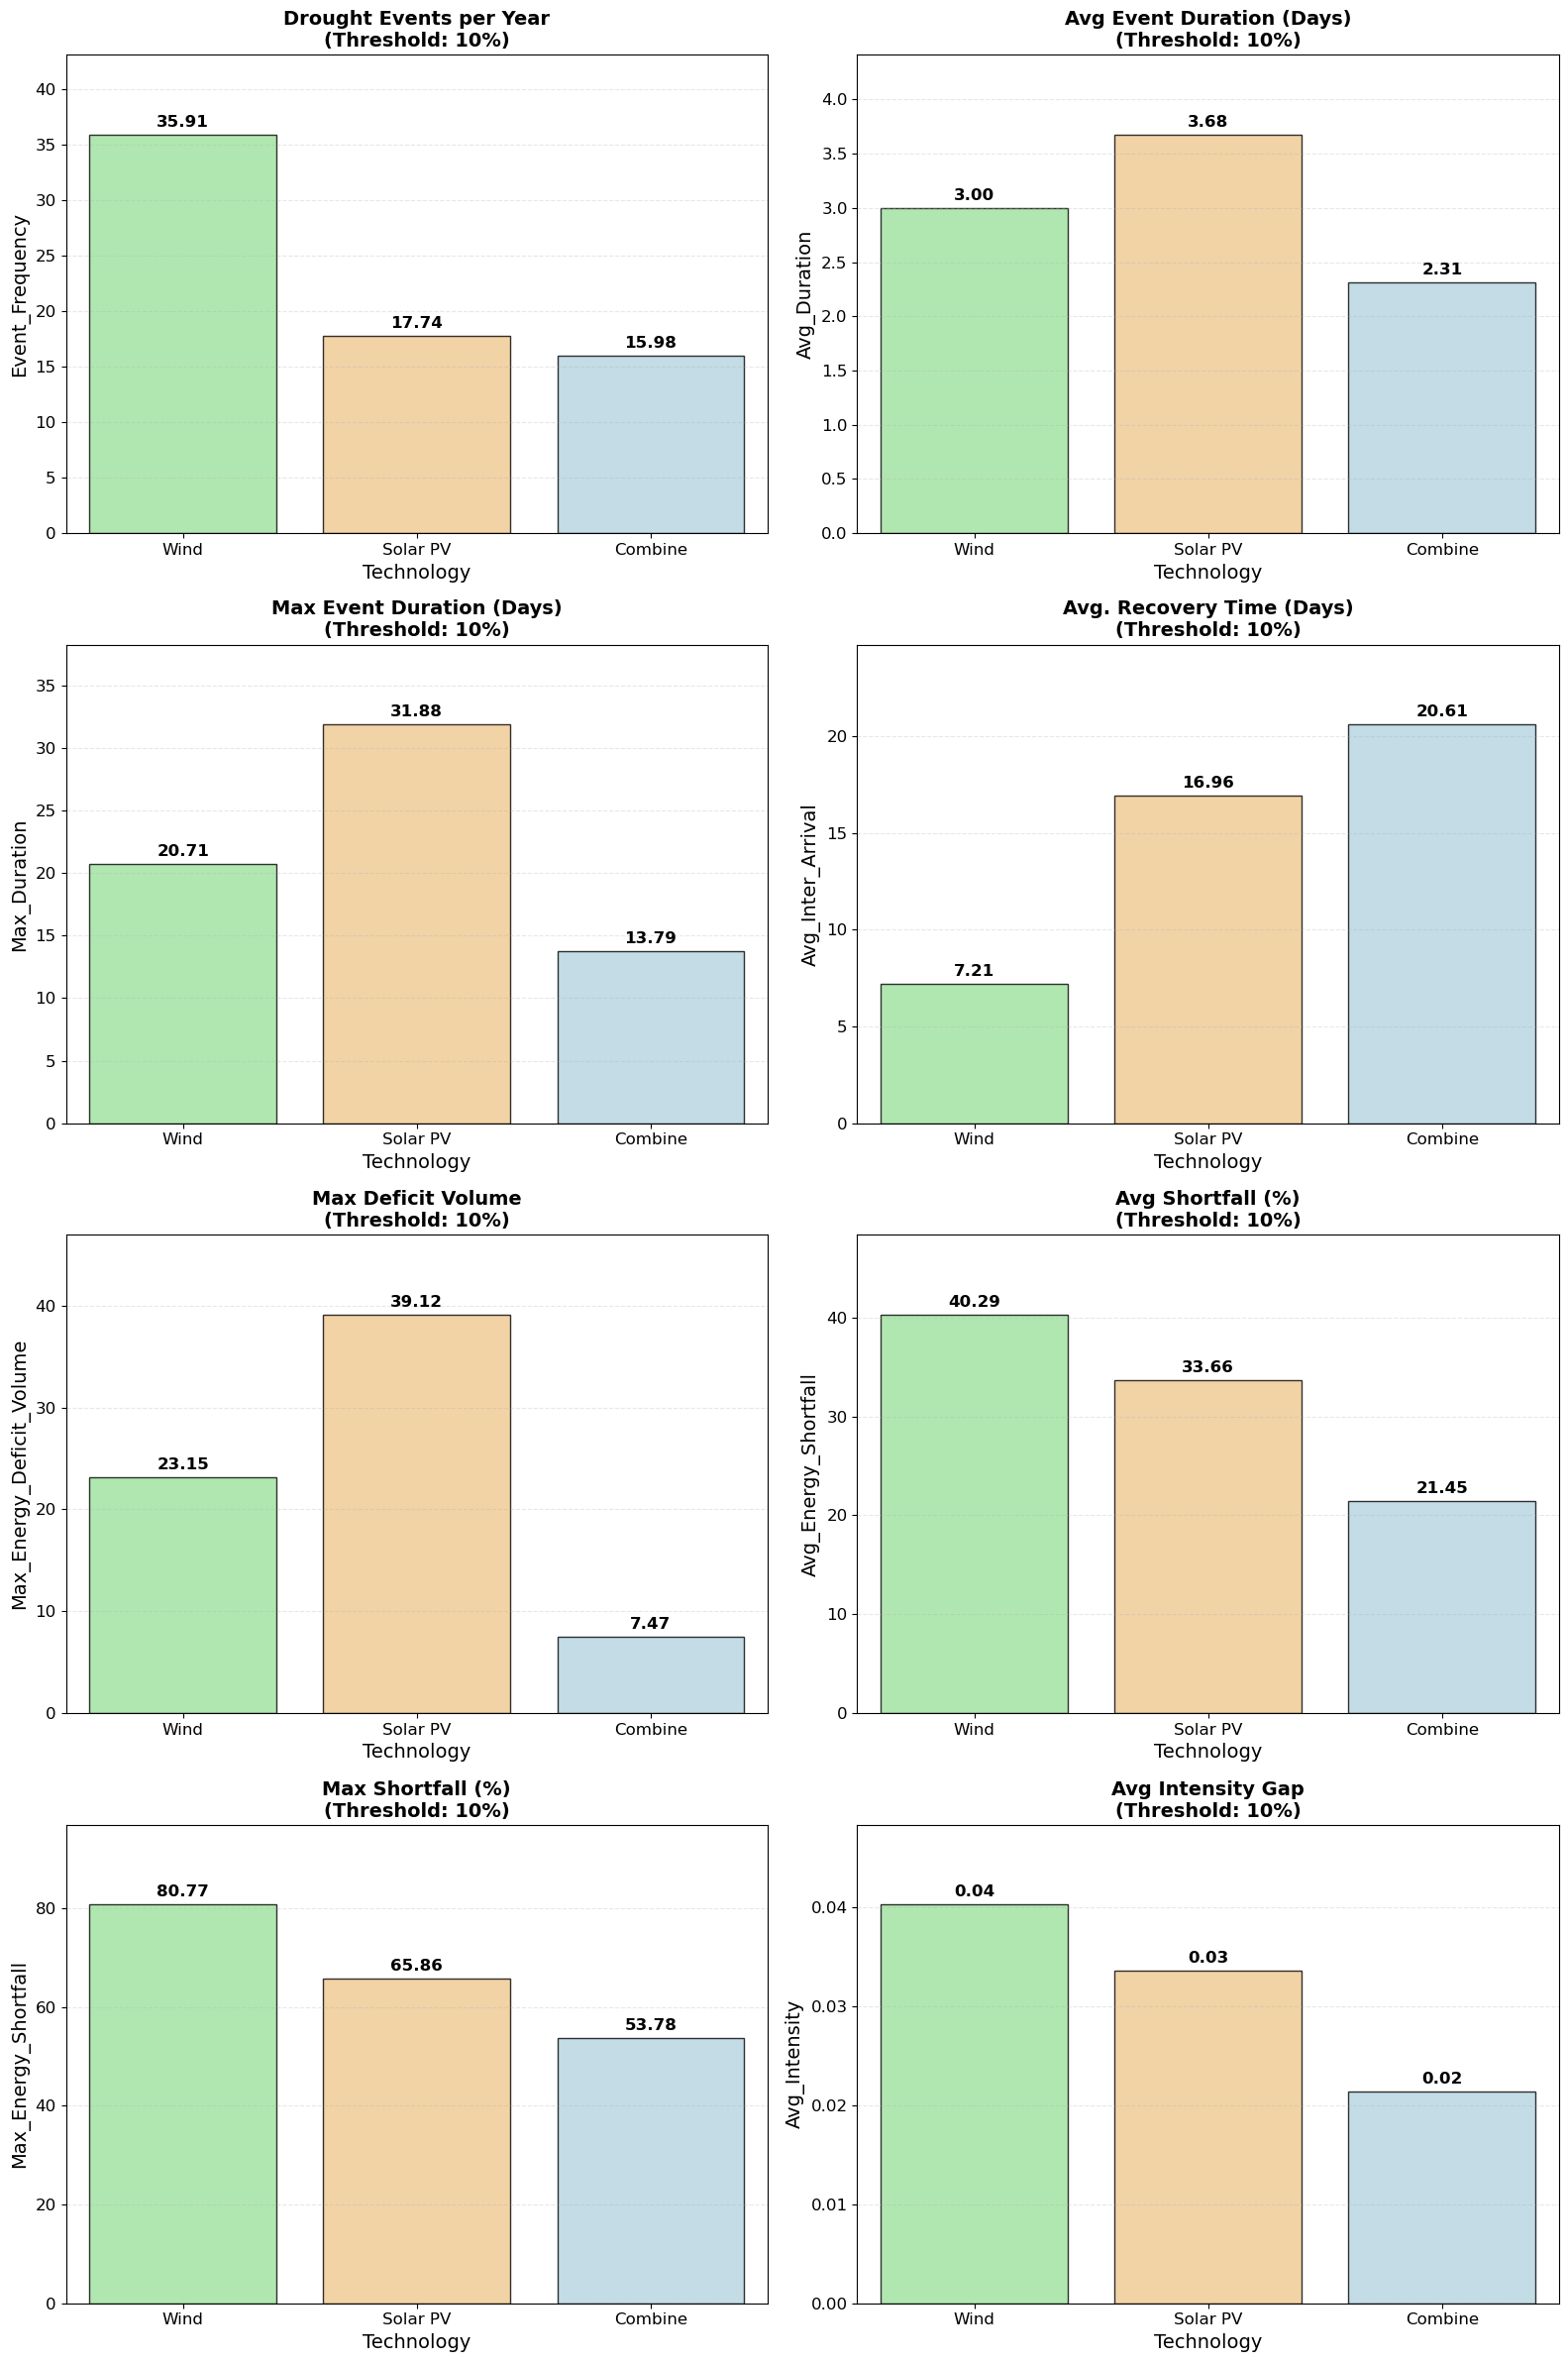

In [11]:
# -----------------------------------------------------------------------------
# 1. METRICS CALCULATION
# -----------------------------------------------------------------------------
summary_metrics = [] 

for tech in columns_to_analyze:
    df_ev = droughts_dict[tech].copy()
    if not df_ev.empty:
        df_ev = df_ev.sort_values('Start_Date')
        
        # INTER-ARRIVAL: Recovery Time between identified drought events
        inter_arrival = (df_ev['Start_Date'] - df_ev['End_Date'].shift(1)).dt.total_seconds() / (3600 * 24)
        avg_recovery_days = inter_arrival.mean()

        event_volumes = []
        event_shortfalls = []
        event_intensities = [] 
        
        for idx, row in df_ev.iterrows():
            # Slice data strictly to the specific drought event duration
            event_mask = (df_cf_avg.index >= row['Start_Date']) & (df_cf_avg.index <= row['End_Date'])
            event_data = df_cf_avg.loc[event_mask, tech]
            
            # 1. Energy Deficit Volume (Cumulative gap below threshold)
            hourly_gap = threshold - event_data
            total_event_volume = hourly_gap.sum() 
            event_volumes.append(total_event_volume)
            
            # 2. Energy Shortfall % (Volume relative to threshold demand)
            total_required = threshold * len(event_data)
            shortfall_pct = (total_event_volume / total_required) * 100 if total_required > 0 else 0
            event_shortfalls.append(shortfall_pct)

            # 3. Drought Intensity (Mean gap during this specific event)
            event_intensities.append(hourly_gap.mean())

        summary_metrics.append({
            'Technology': tech,
            'Event_Frequency': len(df_ev) / total_years,
            'Avg_Duration': df_ev['Duration_d'].mean(),
            'Max_Duration': df_ev['Duration_d'].max(),
            'Avg_Inter_Arrival': avg_recovery_days,
            'Max_Energy_Deficit_Volume': np.max(event_volumes),
            'Max_Energy_Shortfall': np.max(event_shortfalls),
            'Avg_Energy_Shortfall': np.mean(event_shortfalls),
            'Avg_Intensity': np.mean(event_intensities) # Average intensity across all droughts
        })

df_summary_final = pd.DataFrame(summary_metrics)

# -----------------------------------------------------------------------------
# Portfolio Analysis & Gain Calculation
# -----------------------------------------------------------------------------
def get_radar_data(tech):
    row = df_summary_final[df_summary_final['Technology'] == tech].iloc[0]
    return np.array([
        row['Event_Frequency'], row['Avg_Duration'], row['Max_Duration'],
        row['Avg_Inter_Arrival'], row['Max_Energy_Deficit_Volume'], 
        row['Max_Energy_Shortfall'], row['Avg_Energy_Shortfall'], row['Avg_Intensity']
    ])

# Calculate Gains for the Portfolio
# Baseline = Average of individual Wind and Solar performance
baseline = (get_radar_data('Wind') + get_radar_data('Solar PV')) / 2
combine = get_radar_data('Combine')

# Gain calculation (1 - Combined/Baseline) * 100
gains = (1 - (combine / baseline)) * 100
# Recovery time gain: higher is better (longer gaps), so inversion is different
gains[3] = (combine[3] / baseline[3] - 1) * 100 

# -----------------------------------------------------------------------------
# Plots
# -----------------------------------------------------------------------------
labels = ['Frequency', 'Avg Duration', 'Max Duration', 'Avg Recovery Time',
          'Max Deficit', 'Max Shortfall', 'Avg Shortfall', 'Intensity']
num_vars = len(labels)

# RADAR CHART
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
gains_plot = np.concatenate((gains, [gains[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.fill(angles, gains_plot, color=colors_dict['Combine'], alpha=0.3)
ax.plot(angles, gains_plot, color=colors_dict['Combine'], linewidth=2, marker='o')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontweight='bold', fontsize=10)
ax.set_ylim(0, 100) 

plt.title('Portfolio Diversification Gains (%)\nRelative to Wind/Solar Baseline', y=1.1, weight='bold', fontsize=15)
plt.savefig(os.path.join(output_dir, '04_Portfolio_Gains_Radar.png'), dpi=300, bbox_inches='tight')
plt.show()

# BAR CHARTS
metrics_map = [
    ('Event_Frequency', 'Drought Events per Year'),
    ('Avg_Duration', 'Avg Event Duration (Days)'),
    ('Max_Duration', 'Max Event Duration (Days)'),
    ('Avg_Inter_Arrival', 'Avg. Recovery Time (Days)'),
    ('Max_Energy_Deficit_Volume', 'Max Deficit Volume'),
    ('Avg_Energy_Shortfall', 'Avg Shortfall (%)'),
    ('Max_Energy_Shortfall', 'Max Shortfall (%)'),
    ('Avg_Intensity', 'Avg Intensity Gap')
]

fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for i, (col_name, title) in enumerate(metrics_map):
    sns.barplot(data=df_summary_final, x='Technology', y=col_name, hue='Technology',
                legend=False, ax=axes[i], palette=colors_dict, edgecolor='black', alpha=0.8)
    axes[i].set_title(f"{title}\n(Threshold: {int(threshold*100)}%)", fontweight='bold', fontsize=14)
    axes[i].grid(axis='y', ls='--', alpha=0.3)
    
    # Adjust Y-lim to fit annotations
    current_max = df_summary_final[col_name].max()
    axes[i].set_ylim(0, current_max * 1.2 if current_max > 0 else 1)
    
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width()/2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------
#  EXPORT
# -----------------------------------------------------------------------------
report_path = os.path.join(output_dir, 'Output_Report.xlsx')

if not os.path.exists(report_path):
    with pd.ExcelWriter(report_path, engine='openpyxl', mode='w') as writer:
        df_summary_final.to_excel(writer, sheet_name='Metrics', index=False)
else:
    with pd.ExcelWriter(report_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df_summary_final.to_excel(writer, sheet_name='Metrics', index=False)

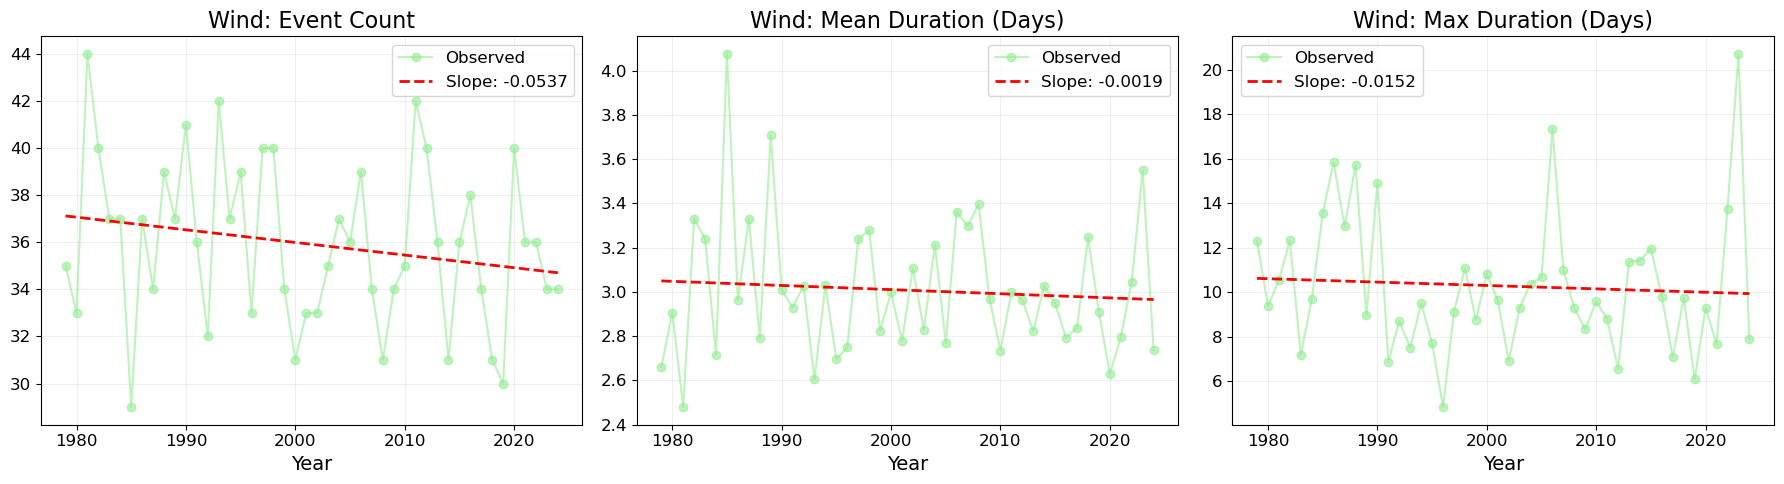

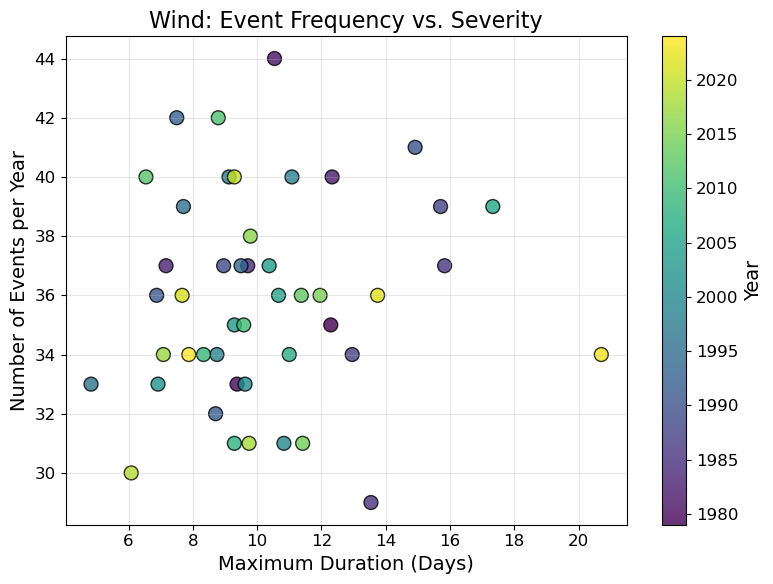

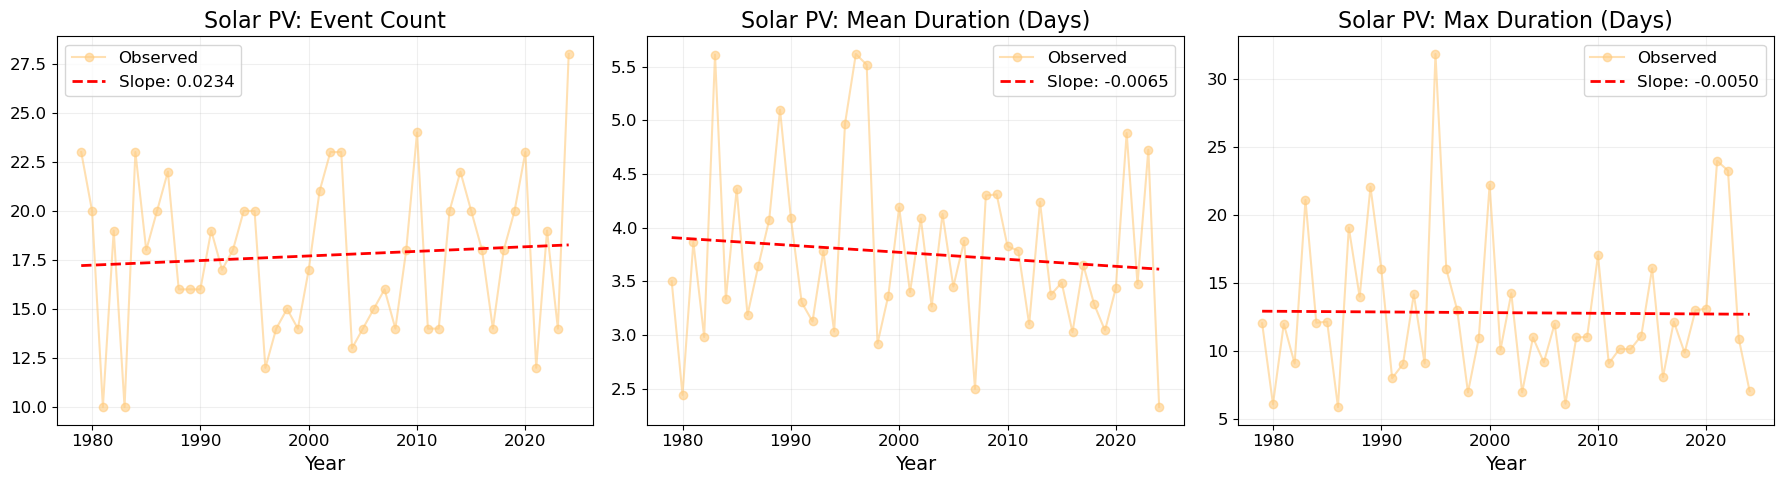

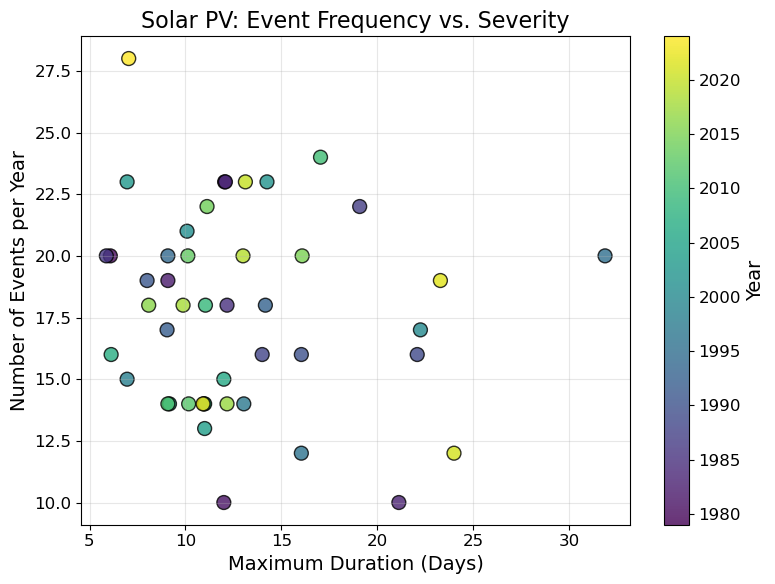

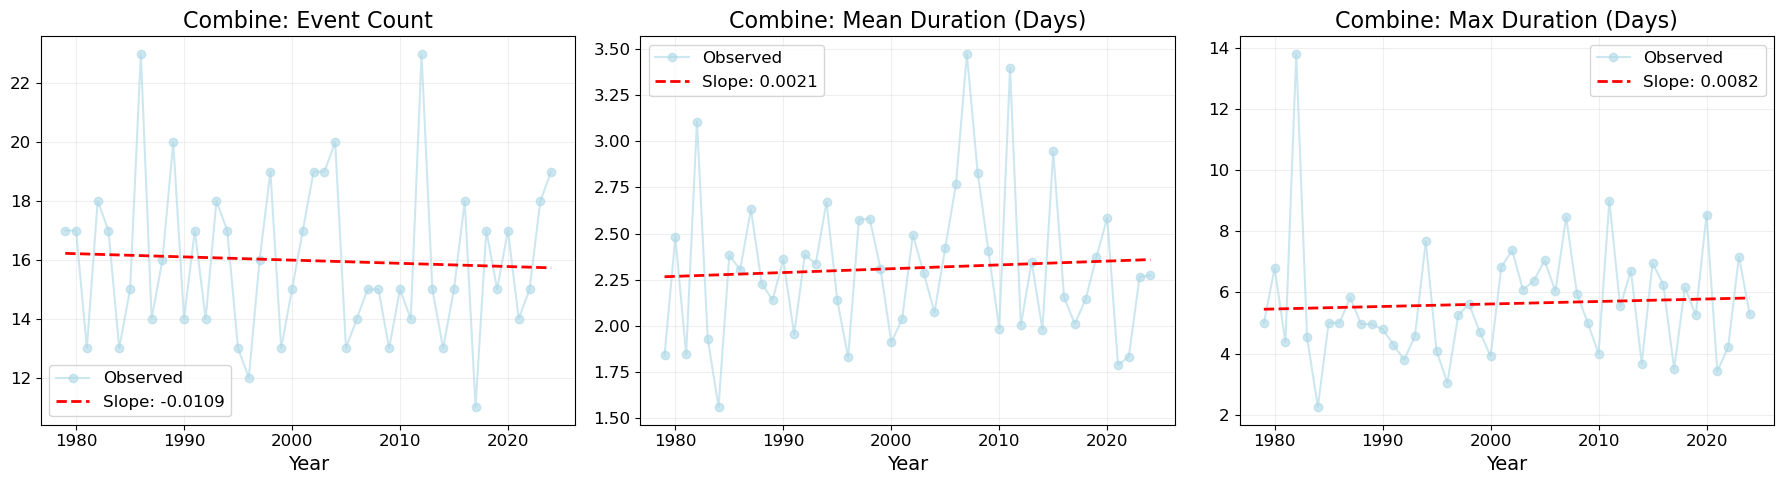

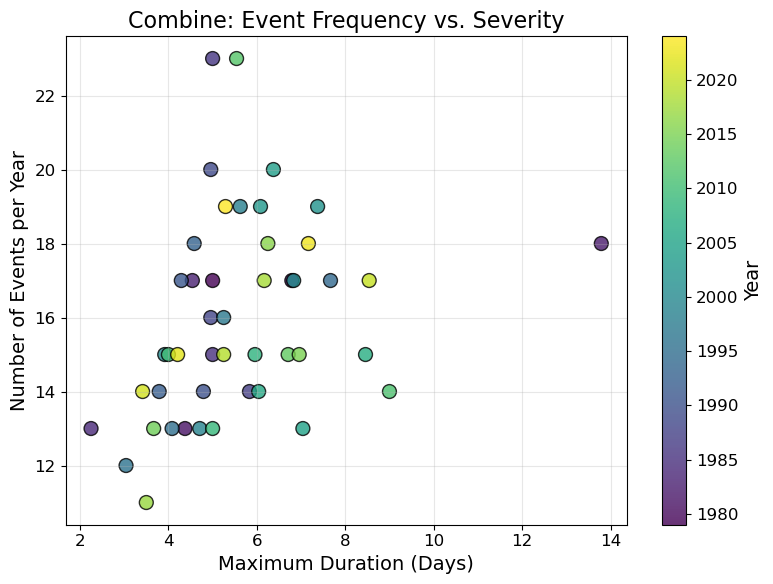

In [30]:
# -----------------------------------------------------------------------------
#   TREND ANALYSIS & SCATTER PLOTS  
# -----------------------------------------------------------------------------

trend_summary_list = []

for i, col in enumerate(columns_to_analyze):
    df_events = droughts_dict[col].copy()
    
    # 1. Calculate Yearly Statistics
   
    yearly_stats = df_events.groupby('Year').agg(
        NrEvents=('Duration_d', 'count'),
        TotalDuration=('Duration_d', 'sum'),
        MeanDuration=('Duration_d', 'mean'),
        MaxDuration=('Duration_d', 'max')
    ).reindex(all_years, fill_value=0) 

    # 2. Perform Linear Regression for each metric
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = ['NrEvents', 'MeanDuration', 'MaxDuration']
    titles = ['Event Count', 'Mean Duration (Days)', 'Max Duration (Days)']
    
    for idx, metric in enumerate(metrics):
        y = yearly_stats[metric].values
        x = np.array(all_years)
        
        # Calculate linear regression: y = slope * x + intercept
        slope, intercept, r, p, stderr = linregress(x, y)
        
        trend_summary_list.append({
            'Technology': col, 
            'Metric': metric, 
            'Slope': slope, 
            'p-value': p, 
            'R2': r**2
        })

        # Plot Yearly Values + Trend Line
        axes[idx].plot(x, y, marker='o', color=colors_dict[col], alpha=0.6, label='Observed')
        axes[idx].plot(x, intercept + slope*x, 'r--', linewidth=2, label=f'Slope: {slope:.4f}')
        
        axes[idx].set_title(f'{col}: {titles[idx]}')
        axes[idx].set_xlabel('Year')
        axes[idx].grid(True, alpha=0.2)
        axes[idx].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'04_Trends_{col.replace(" ", "_")}.png'), dpi=300)
    plt.show()

    # 3. Scatter Plot: Frequency vs. Maximum Severity
   
    
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(yearly_stats['MaxDuration'], yearly_stats['NrEvents'],
                     c=yearly_stats.index.values, cmap='viridis', s=100, edgecolor='k', alpha=0.8)
    
    plt.xlabel('Maximum Duration (Days)')
    plt.ylabel('Number of Events per Year')
    plt.title(f'{col}: Event Frequency vs. Severity')
    cbar = plt.colorbar(sc)
    cbar.set_label('Year')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'05_Scatter_{col.replace(" ", "_")}.png'), dpi=300)
    plt.show()

# if needed, Update  Excel export section to include this:
# pd.DataFrame(trend_summary_list).to_excel(writer, sheet_name='Trend_Analysis', index=False)

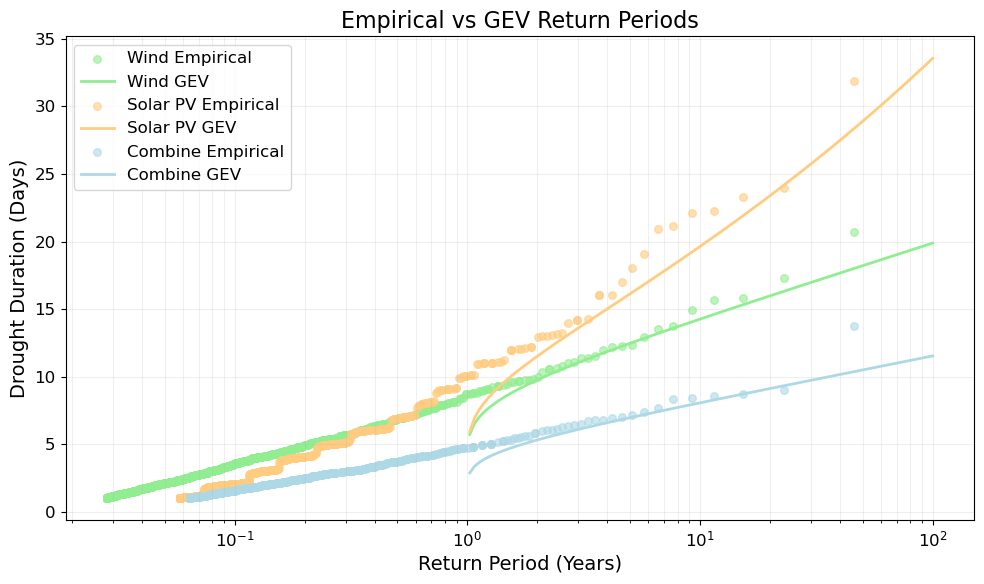

In [13]:
 
# Comapare extreme events methods - GEV vs. Boris et al. - Specially 
# It can be relevant when the dataset is reduced
# ---------------------------

from scipy.stats import rankdata


def calculate_return_period_empirical(droughts_df, total_years):
   
    df = droughts_df.copy()
    df = df.sort_values('Duration_d')  # sort by duration
    df['rank'] = rankdata(df['Duration_d'], method='average')
    N = len(df)
    df['return_period_events'] = (N + 1) / (N - df['rank'] + 1)  # plotting position
    df['return_years'] = df['return_period_events'] * total_years / N
    return df

 
empirical_rp_dict = {}
for col in columns_to_analyze:
    empirical_rp_dict[col] = calculate_return_period_empirical(droughts_dict[col], total_years)

# ---------------------------
# GEV vs Empirical
# ---------------------------
plt.figure(figsize=(10,6))
for col in columns_to_analyze:
    # Empirical
    df_emp = empirical_rp_dict[col]
    plt.scatter(df_emp['return_years'], df_emp['Duration_d'], 
                color=colors_dict[col], alpha=0.6, s=30, label=f'{col} Empirical')
    
    # GEV
    df_gev = droughts_dict[col].groupby('Year')['Duration_d'].max().sort_values()
    shape, loc, scale = gev.fit(df_gev.values)
    target_rp = np.logspace(0.01, 2, 100)
    gev_curve = gev.ppf(1 - 1/target_rp, shape, loc, scale)
    plt.plot(target_rp, gev_curve, color=colors_dict[col], lw=2, label=f'{col} GEV')

plt.xscale('log')
plt.xlabel('Return Period (Years)')
plt.ylabel('Drought Duration (Days)')
plt.title('Empirical vs GEV Return Periods')
plt.legend()
plt.grid(True, which='both', alpha=0.2)
plt.tight_layout()
plt.show()

